In [8]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# 이미지 데이터 경로 설정
data_dir = 'fer2013_train' # 폴더 경로 설정 (사이즈 작은 이미지 / fer2013 테스트)
input_shape = (48, 48)
batch_size = 32
num_classes = 7  # 클래스 개수에 맞게 설정

# 훈련셋, 검증셋, 테스트셋으로 데이터 나누기 + 전처리
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # 훈련셋 80%, 검증셋 20%
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 훈련셋 제너레이터 생성
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 'training' subset은 훈련셋으로 사용
)

# 검증셋 제너레이터 생성
valid_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 'validation' subset은 검증셋으로 사용
)

# 테스트셋 제너레이터 생성
test_dir = 'fer2013_test'
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset=None 
)


# 모델 체크포인트 콜백 정의
checkpoint_path = 'DenseNet_testcode_V7_2100test_01.h5'
checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy',  # 저장할 모델을 선택할 지표 설정 (여기서는 검증 정확도)
    save_best_only=True,     # 최상의 성능을 보이는 경우에만 저장
    mode='max',              # 지표의 최대값을 찾음
    verbose=1                # 저장할 때 메시지 출력
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
def DenseNet(x):
    # input = 224 x 224 x 3
    k = 32  # Grow Rate
    compression = 0.2   # 밀집 블록 내에서 출력 채널 수를 줄임 (모델의 파라미터 수와 연산량을 줄이면서도 효과적인 특성 추출)


    # 1. Convolution
    # 입력 이미지에 7x7 크기의 필터를 사용하는 Convolution 레이어를 적용
    x = layers.Conv2D(k * 2, (7, 7), strides=2, padding='same', input_shape=(48, 48, 3))(x)    # 112x112x64
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # 2. Pooling
    # 이미지 내의 중요한 특성을 보존하면서 크기를 줄임
    x = layers.MaxPool2D((3, 3), 2, padding='same')(x)  # 56x56x64


    # 5. Dense Block (2)
    for i in range(1) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])


    # 6. Transition Layer (2)
    current_shape = int(x.shape[-1])
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 14x14


    # 7. Dense Block (3)
    for i in range(24) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 8. Transition Layer (3)
    current_shape = int(x.shape[-1])
    x = layers.Conv2D(int(current_shape * compression), (1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)   # 7x7


    # 9. Dense Block (4)
    for i in range(1) :
        x_l = layers.Conv2D(k * 4, (1, 1), strides=1, padding='same')(x)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x_l = layers.Conv2D(k, (3, 3), strides=1, padding='same')(x_l)
        x_l = layers.BatchNormalization()(x_l)
        x_l = layers.Activation('relu')(x_l)

        x = layers.Concatenate()([x, x_l])

    # 10. Classification Layer
    x = layers.GlobalAveragePooling2D()(x)
    # classes = 7 (softmax)
    x = layers.Dense(7, activation='softmax')(x)

    return x

In [11]:
# 모델 생성
input_layer = layers.Input(shape=(*input_shape, 3), dtype='float32', name='input')
output_layer = DenseNet(input_layer)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [12]:
# 클래스 개수 설정
num_classes = 7

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy',  # 다중 클래스 분류용 함수
              metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d_55 (Conv2D)          (None, 24, 24, 64)           9472      ['input[0][0]']               
                                                                                                  
 batch_normalization_55 (Ba  (None, 24, 24, 64)           256       ['conv2d_55[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_55 (Activation)  (None, 24, 24, 64)           0         ['batch_normalization_55

                                                                                                  
 conv2d_60 (Conv2D)          (None, 6, 6, 32)             36896     ['activation_59[0][0]']       
                                                                                                  
 batch_normalization_60 (Ba  (None, 6, 6, 32)             128       ['conv2d_60[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_60 (Activation)  (None, 6, 6, 32)             0         ['batch_normalization_60[0][0]
                                                                    ']                            
                                                                                                  
 concatenate_27 (Concatenat  (None, 6, 6, 51)             0         ['average_pooling2d_2[0][0]', 
 e)       

In [13]:
# model = tf.keras.models.load_model(checkpoint_path) # checkpoint 모델 불러오기

In [14]:
# 모델 학습
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

# 훈련 과정의 손실과 정확도 추출
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# 테스트셋 평가
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

# 결과 출력
print("Training Loss:", train_loss)
print("Training Accuracy:", train_acc)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
718/718 [==============================] - 444s 604ms/step - loss: 1.7914 - acc: 0.2567 - val_loss: 1.8010 - val_acc: 0.2619
Epoch 2/10
718/718 [==============================] - 410s 571ms/step - loss: 1.6697 - acc: 0.3355 - val_loss: 3.5579 - val_acc: 0.1301
Epoch 3/10
718/718 [==============================] - 398s 555ms/step - loss: 1.5500 - acc: 0.3949 - val_loss: 1.6239 - val_acc: 0.3539
Epoch 4/10
718/718 [==============================] - 339s 472ms/step - loss: 1.4591 - acc: 0.4313 - val_loss: 1.4996 - val_acc: 0.4227
Epoch 5/10
718/718 [==============================] - 346s 482ms/step - loss: 1.3976 - acc: 0.4606 - val_loss: 1.7261 - val_acc: 0.3069
Epoch 6/10
718/718 [==============================] - 359s 499ms/step - loss: 1.3448 - acc: 0.4839 - val_loss: 1.4222 - val_acc: 0.4539
Epoch 7/10
718/718 [==============================] - 350s 487ms/step - loss: 1.3031 - acc: 0.5026 - val_loss: 1.6535 - val_acc: 0.3767
Epoch 8/10
718/718 [============================

KeyError: 'accuracy'

In [15]:
# 클래스 이름과 인덱스 매핑 출력
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


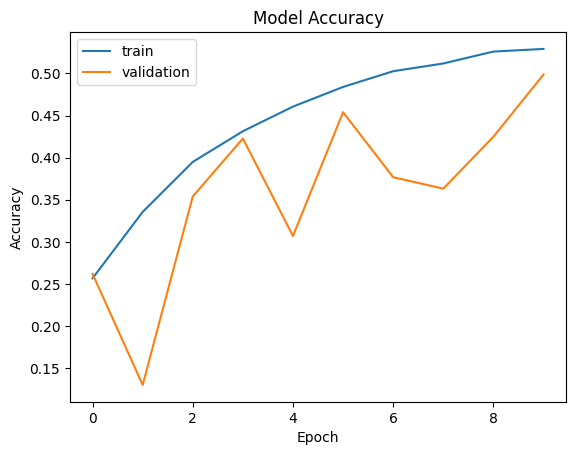

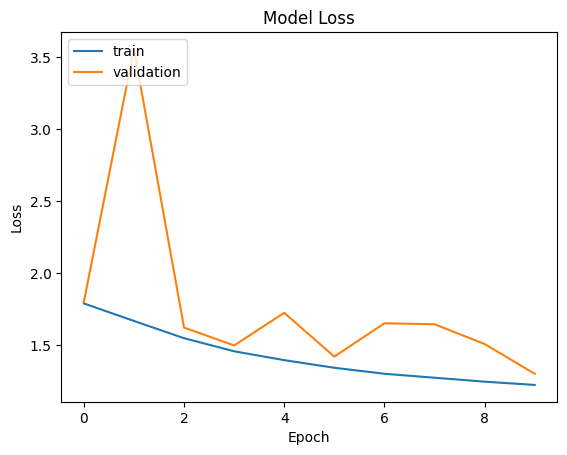

In [16]:
# Accuracy 그래프
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## 하나의 이미지 분석해보기

In [19]:
# 하나의 이미지 분석해보기
# 이미지 파일 경로
image_path = 'face1.jpg'

# 이미지 전처리
input_image = cv2.imread(image_path)
input_image = cv2.resize(input_image, input_shape)
input_image = input_image / 255.0  # [0, 1] 범위로 정규화
input_image = np.expand_dims(input_image, axis=0)  # 모델은 배치 입력을 사용하므로 차원 확장

# 감정 예측
predicted_probs = model.predict(input_image)
predicted_emotion_index = np.argmax(predicted_probs)
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
predicted_emotion = emotion_classes[predicted_emotion_index]

print("Predicted emotion:", predicted_emotion)

1/1 [==============================] - 0s 37ms/step
Predicted emotion: happy


In [21]:
# 각 감정들의 확률 출력
for emotion, prob in zip(emotion_classes, predicted_probs[0]):
    percentage = prob * 100
    print(f"감정: {emotion} \t\t확률: {percentage:.2f}%")

감정: angry 		확률: 2.51%
감정: disgust 		확률: 0.12%
감정: fear 		확률: 4.65%
감정: happy 		확률: 75.05%
감정: sad 		확률: 1.07%
감정: surprise 		확률: 0.53%
감정: neutral 		확률: 16.07%
